# Rossmann Sales Forecasting — 01 Data Analysis (EDA)

**Objectif :** analyser les données Rossmann (train/test/store), identifier les patterns et anomalies, et en déduire des décisions concrètes pour le notebook **02_pretratment.ipynb** (feature engineering + split + modèle).

**Contexte Kaggle :** prédire `Sales` sur 6 semaines pour 1 115 magasins.

**Évaluation :** RMSPE (Root Mean Square Percentage Error). Les observations avec `Sales = 0` sont ignorées au scoring (donc il faut traiter explicitement les jours fermés / ventes nulles).

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

DATA_DIR = Path("data")

# Accéder a `data/` dans le repertoire parent:
NOTEBOOK_DIR = Path.cwd()
PROJECT_DIR = NOTEBOOK_DIR.parent          # => .../rossmann-kaggle
DATA_DIR = PROJECT_DIR / "data"


## Plan

1. Chargement et aperçu des données  
2. Contrôles de qualité (types, doublons, valeurs manquantes)  
3. Analyse de la cible (Sales) et des jours fermés  
4. Analyse temporelle (jour semaine, mois, tendance)  
5. Effets des variables opérationnelles (Promo, Holidays)  
6. Variables magasin (StoreType, Assortment, Competition, Promo2)  
7. Synthèse : implications pour le prétraitement et les features

## 1) Évaluation : RMSPE

$RMSPE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}\left(\frac{y_i-\hat{y}_i}{y_i}\right)^2}$.

Sur Kaggle, les points avec `Sales = 0` sont ignorés, donc on reproduit ce comportement localement avec un masque `y > 0`.

In [10]:
def rmspe(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true > 0
    return np.sqrt(np.mean(((y_true[mask] - y_pred[mask]) / y_true[mask])**2))

## 2) Chargement des données & Aperçu global

On charge :
- `train.csv` : contient `Sales` (cible)
- `test.csv` : pas de `Sales`
- `store.csv` : infos magasin (fixes)

On parse `Date` et on trie par `(Store, Date)` pour faciliter les analyses temporelles.

On inspecte rapidement l'aperçu global:
- premières lignes & colonnes
- types

In [11]:
train = pd.read_csv(DATA_DIR / "train.csv", parse_dates=["Date"], low_memory=False)
test  = pd.read_csv(DATA_DIR / "test.csv",  parse_dates=["Date"], low_memory=False)
store = pd.read_csv(DATA_DIR / "store.csv", low_memory=False)

train = train.sort_values(["Store", "Date"]).reset_index(drop=True)
test  = test.sort_values(["Store", "Date"]).reset_index(drop=True)

# (Store, Date)
print("Shapes:", train.shape, test.shape, store.shape)
# Premiere lignes / colonnes
display(train.head(20))
# Types
display(train.dtypes)

Shapes: (1017209, 9) (41088, 8) (1115, 10)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,2,2013-01-01,0,0,0,0,a,1
1,1,3,2013-01-02,5530,668,1,0,0,1
2,1,4,2013-01-03,4327,578,1,0,0,1
3,1,5,2013-01-04,4486,619,1,0,0,1
4,1,6,2013-01-05,4997,635,1,0,0,1
5,1,7,2013-01-06,0,0,0,0,0,1
6,1,1,2013-01-07,7176,785,1,1,0,1
7,1,2,2013-01-08,5580,654,1,1,0,1
8,1,3,2013-01-09,5471,626,1,1,0,1
9,1,4,2013-01-10,4892,615,1,1,0,1


Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Sales                     int64
Customers                 int64
Open                      int64
Promo                     int64
StateHoliday             object
SchoolHoliday             int64
dtype: object

## 3) Qualité des données

On vérifie :
- **doublons** sur `(Store, Date)`
- **intervalle de dates** train/test
- **valeurs manquantes** (particulièrement dans `store.csv`: concurrence, Promo2…)

Ces constats guideront l’imputation et la création d’indicateurs “missing”.

In [12]:
print("Train duplicates (Store,Date):", train.duplicated(["Store","Date"]).sum())
print("Test  duplicates (Store,Date):", test.duplicated(["Store","Date"]).sum())
print()

print("Train date range:", train["Date"].min().date(), "->", train["Date"].max().date())
print("Test  date range:", test["Date"].min().date(), "->", test["Date"].max().date())
print()

def show_missing(df, name):
    miss = df.isna().sum()
    miss = miss[miss > 0].sort_values(ascending=False)
    out = (miss.to_frame("missing_count"))
    out["missing_pct"] = (out["missing_count"] / len(df) * 100).round(2)
    print(f"{name} — colonnes avec NA: {len(out)}")
    display(out)

show_missing(train, "train")
show_missing(test,  "test")
show_missing(store, "store")

Train duplicates (Store,Date): 0
Test  duplicates (Store,Date): 0

Train date range: 2013-01-01 -> 2015-07-31
Test  date range: 2015-08-01 -> 2015-09-17

train — colonnes avec NA: 0


,missing_count,missing_pct


test — colonnes avec NA: 1


,missing_count,missing_pct
Open,11,0.03


store — colonnes avec NA: 6


,missing_count,missing_pct
Promo2SinceYear,544,48.79
Promo2SinceWeek,544,48.79
PromoInterval,544,48.79
CompetitionOpenSinceMonth,354,31.75
CompetitionOpenSinceYear,354,31.75
CompetitionDistance,3,0.27


## 4) Fusion avec `store.csv`

On enrichit `train` et `test` avec les informations “statiques” de chaque magasin contenues dans `store.csv` (type de magasin, assortiment, concurrence, Promo2, etc.).

On effectue une jointure **à gauche** (`how="left"`) sur la clé `Store` :
- **Objectif** : conserver **exactement** toutes les lignes de `train` et `test`, et ajouter les colonnes de `store`.
- **Vérification** : après jointure, le nombre de lignes doit rester identique (pas de duplication, pas de perte).

Enfin, on mesure le **taux de valeurs manquantes** après jointure, afin d’identifier les variables susceptibles de nécessiter un traitement ultérieur (imputation, indicateurs de manquants, etc.).  

In [13]:
train_m = train.merge(store, on="Store", how="left")
test_m  = test.merge(store,  on="Store", how="left")

print("train:", train.shape, "->", train_m.shape)
print("test :", test.shape,  "->", test_m.shape)

# Taux de valeurs manquante apres jointure
(train_m.isna().mean()
    .sort_values(ascending=False)
    .head(15))

train: (1017209, 9) -> (1017209, 18)
test : (41088, 8) -> (41088, 17)


Promo2SinceWeek              0.499436
PromoInterval                0.499436
Promo2SinceYear              0.499436
CompetitionOpenSinceYear     0.317878
CompetitionOpenSinceMonth    0.317878
CompetitionDistance          0.002597
DayOfWeek                    0.000000
Store                        0.000000
Date                         0.000000
Sales                        0.000000
StoreType                    0.000000
SchoolHoliday                0.000000
StateHoliday                 0.000000
Promo                        0.000000
Open                         0.000000
dtype: float64

## 5) Distribution de `Sales` et jours fermés (`Open`)

Dans le jeu de données :
- `Open = 0` signifie que le magasin est fermé.
- `Sales = 0` apparaît très souvent quand `Open = 0`, mais pas uniquement (cas particuliers / erreurs / exceptions).
- **RMSPE (Kaggle)** : les jours avec `Sales = 0` sont ignorés dans le scoring.  
  ➜ Le modèle doit donc apprendre principalement sur les jours **ouverts**, et en prédiction on devra gérer séparément les jours **fermés**.

Dans cette section, on :
1) mesure la proportion de jours fermés et les cas incohérents éventuels  
2) observe la distribution de `Sales` sur les jours ouverts (`Open = 1`)  
3) regarde une transformation `log1p(Sales)` car la distribution est généralement très asymétrique

### 5.1) Vérification jours fermés + cas incohérents

On vérifie :
- proportion de `Open = 0` et `Open = 1`
- cas “surprenants” :
  - `Open = 1` & `Sales = 0`
  - `Open = 0` & `Sales > 0`

⚠️ Warning : ces cas existent parfois (exceptions, fermetures partielles, données manquantes, etc.).  
➡️ Décision (pour le notebook 02) : définir une règle robuste (ex : entraînement sur `Open=1`, et forcer `Sales=0` quand `Open=0` au moment de la prédiction).

In [14]:
# Open vs Sales
print("Open=1 ratio:", (train_m["Open"] == 1).mean())
print("Open=0 ratio:", (train_m["Open"] == 0).mean())
print("Sales==0 ratio:", (train_m["Sales"] == 0).mean())

open1_sales0 = train_m[(train_m["Open"] == 1) & (train_m["Sales"] == 0)]
open0_salespos = train_m[(train_m["Open"] == 0) & (train_m["Sales"] > 0)]

print("Open=1 & Sales=0:", len(open1_sales0))
print("Open=0 & Sales>0:", len(open0_salespos))

open1_sales0[["Store","Date","DayOfWeek","Promo","StateHoliday","SchoolHoliday","Customers"]].head()

Open=1 ratio: 0.8301066939045958
Open=0 ratio: 0.16989330609540418
Sales==0 ratio: 0.16994639253093513
Open=1 & Sales=0: 54
Open=0 & Sales>0: 0


,Store,Date,DayOfWeek,Promo,StateHoliday,SchoolHoliday,Customers
22463,25,2014-02-12,3,0,0,0,0
22464,25,2014-02-13,4,0,0,0,0
25491,28,2014-09-02,2,1,0,1,0
25492,28,2014-09-03,3,1,0,1,0
25493,28,2014-09-04,4,1,0,0,0



### 5.2) Distribution `Open` vs `Sales`

On observe généralement :
- une distribution très asymétrique (longue queue à droite)
- des valeurs extrêmes (certains magasins / jours spécifiques)

Conséquence : appliquer `log1p(Sales)` peut stabiliser la variance et faciliter l’apprentissage (régression, arbres boostés, etc.).

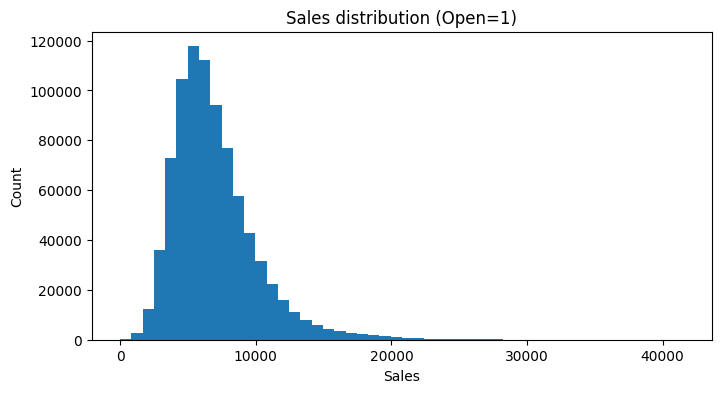

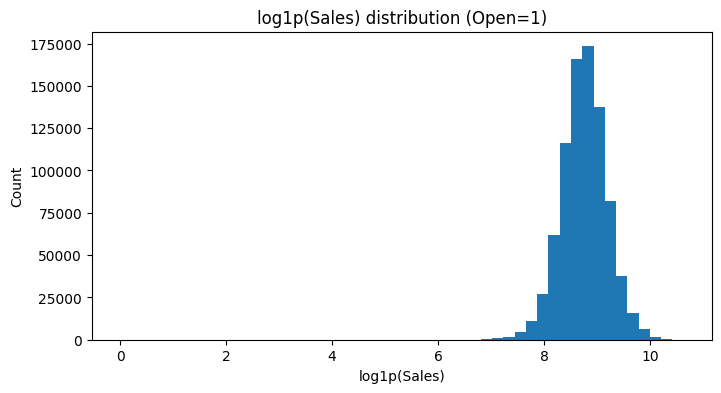

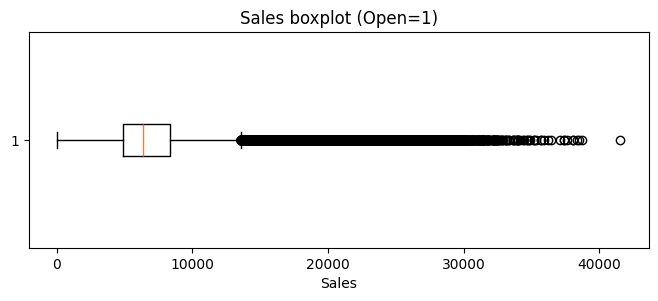

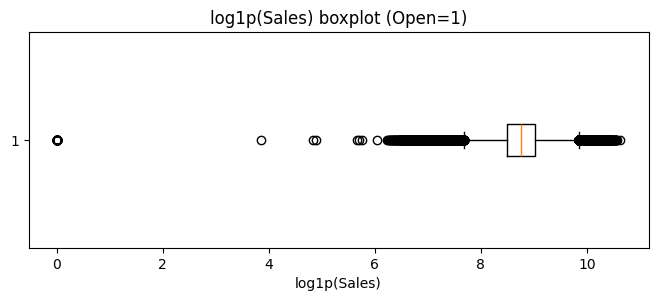

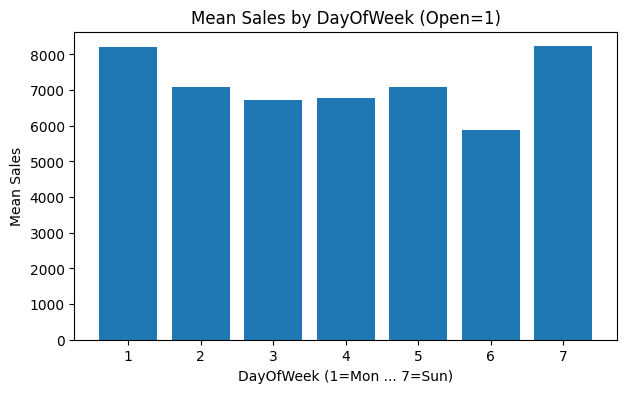

In [15]:
df_open = train_m[train_m["Open"] == 1].copy()

plt.figure(figsize=(8,4))
plt.hist(df_open["Sales"], bins=50)
plt.title("Sales distribution (Open=1)")
plt.xlabel("Sales")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8,4))
plt.hist(np.log1p(df_open["Sales"]), bins=50)
plt.title("log1p(Sales) distribution (Open=1)")
plt.xlabel("log1p(Sales)")
plt.ylabel("Count")
plt.show()

import numpy as np
import matplotlib.pyplot as plt

df_open = train_m[train_m["Open"] == 1].copy()

plt.figure(figsize=(8,2.8))
plt.boxplot(df_open["Sales"], vert=False)
plt.title("Sales boxplot (Open=1)")
plt.xlabel("Sales")
plt.show()

plt.figure(figsize=(8,2.8))
plt.boxplot(np.log1p(df_open["Sales"]), vert=False)
plt.title("log1p(Sales) boxplot (Open=1)")
plt.xlabel("log1p(Sales)")
plt.show()



dow_mean = df_open.groupby("DayOfWeek")["Sales"].mean()

plt.figure(figsize=(7,4))
plt.bar(dow_mean.index.astype(int), dow_mean.values)
plt.title("Mean Sales by DayOfWeek (Open=1)")
plt.xlabel("DayOfWeek (1=Mon ... 7=Sun)")
plt.ylabel("Mean Sales")
plt.show()

### 6) Distribution `Customers` vs `Sales`

`Customers` est généralement très prédictif et est présent aussi dans le test.

⚠️ Warning : la relation peut varier selon StoreType / Promo / saison.
➡️ Décision : tester features et interactions en 02.

Correlation Sales vs Customers (Open=1): 0.8235967321975493


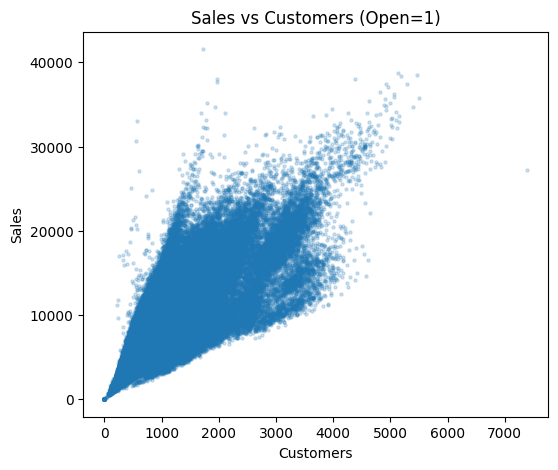

Log1P: Correlation Sales vs Customers (Open=1): 0.8554114571968362


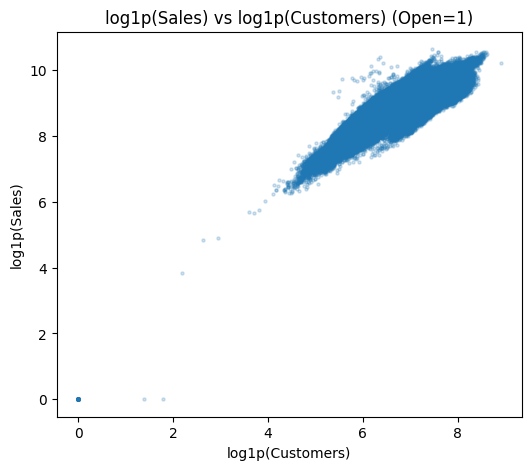

In [17]:
df_open = train_m[train_m["Open"] == 1].copy()

corr = df_open[["Sales","Customers"]].corr().iloc[0,1]
print("Correlation Sales vs Customers (Open=1):", corr)

plt.figure(figsize=(6,5))
plt.scatter(df_open["Customers"], df_open["Sales"], s=5, alpha=0.2)
plt.title("Sales vs Customers (Open=1)")
plt.xlabel("Customers")
plt.ylabel("Sales")
plt.show()

## ?
corr = np.log1p(df_open[["Sales","Customers"]]).corr().iloc[0,1]
print("Log1P: Correlation Sales vs Customers (Open=1):", corr)

plt.figure(figsize=(6,5))
plt.scatter(np.log1p(df_open["Customers"]), np.log1p(df_open["Sales"]), s=5, alpha=0.2)
plt.title("log1p(Sales) vs log1p(Customers) (Open=1)")
plt.xlabel("log1p(Customers)")
plt.ylabel("log1p(Sales)")
plt.show()


## 7) Effet de `Promo`

On compare la distribution de `Sales` selon `Promo`.

⚠️ Warning : l’effet Promo dépend fortement du magasin + du calendrier.
➡️ Décision : inclure Promo et interactions en 02.

<Figure size 640x480 with 0 Axes>

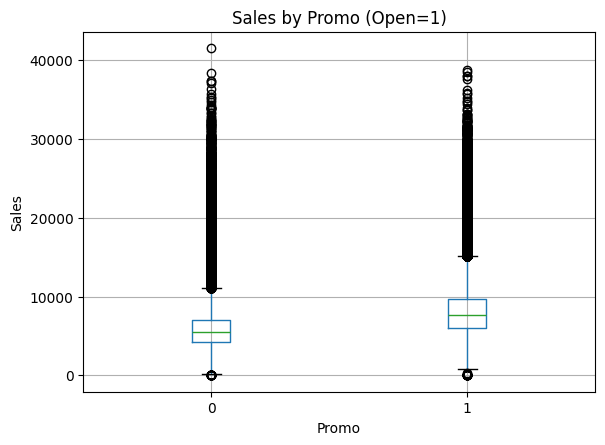

,count,mean,median
Promo,,,
0,467496,5929.407603,5459.0
1,376896,8228.281239,7649.0


In [92]:
plt.figure()
df_open.boxplot(column="Sales", by="Promo")
plt.title("Sales by Promo (Open=1)")
plt.suptitle("")
plt.xlabel("Promo")
plt.ylabel("Sales")
plt.show()

g = df_open.groupby("Promo")["Sales"]
pd.DataFrame({"count": g.size(), "mean": g.mean(), "median": g.median()})

## 10) Saisonnalité (jour de semaine / mois)

On observe des patterns calendaires.

⚠️ Warning : `DayOfWeek` est déjà fourni, mais on va créer `Month/Year/Day` en 02.
➡️ Décision : split temporel + features date en 02.

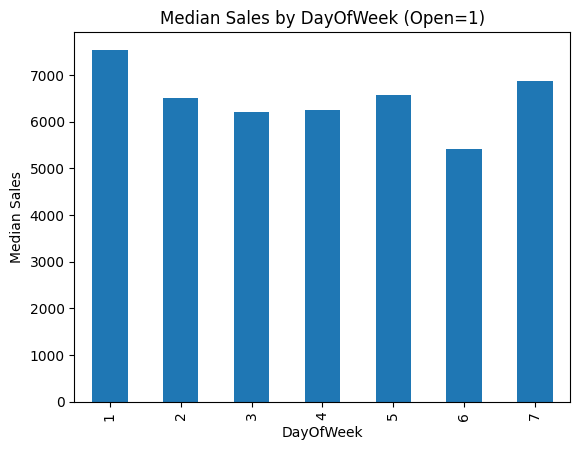

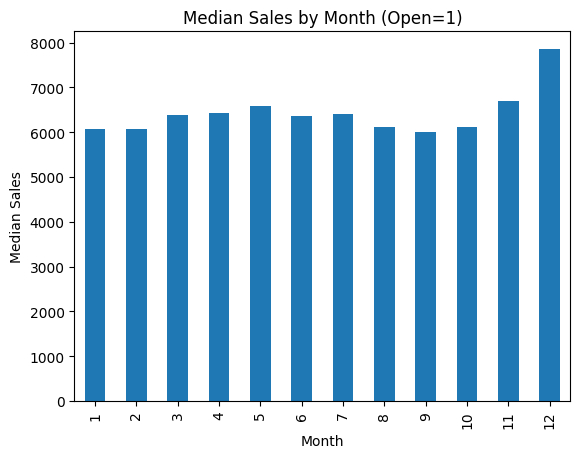

In [93]:
tmp = df_open.copy()
tmp["Year"]  = tmp["Date"].dt.year
tmp["Month"] = tmp["Date"].dt.month

plt.figure()
tmp.groupby("DayOfWeek")["Sales"].median().plot(kind="bar")
plt.title("Median Sales by DayOfWeek (Open=1)")
plt.xlabel("DayOfWeek")
plt.ylabel("Median Sales")
plt.show()

plt.figure()
tmp.groupby("Month")["Sales"].median().plot(kind="bar")
plt.title("Median Sales by Month (Open=1)")
plt.xlabel("Month")
plt.ylabel("Median Sales")
plt.show()

## 11) Comparaison train vs test (shift)

On compare rapidement quelques distributions (Open, Promo, mois).

⚠️ Warning : si le test est distribué différemment, un split random sera trompeur.
➡️ Décision : faire une validation temporelle en 02 (dernières semaines).

In [94]:
test_tmp = test_m.copy()
test_tmp["Month"] = test_tmp["Date"].dt.month

print("Train Open ratio:", (train_m["Open"]==1).mean())
print("Test  Open ratio:", (test_tmp["Open"]==1).mean())

print("Train Promo ratio (Open=1):", df_open["Promo"].mean())
print("Test  Promo ratio:", test_tmp["Promo"].mean())

train_month = df_open["Date"].dt.month.value_counts(normalize=True).sort_index()
test_month  = test_tmp["Date"].dt.month.value_counts(normalize=True).sort_index()
pd.DataFrame({"train_open_month": train_month, "test_month": test_month}).fillna(0)

Train Open ratio: 0.8301066939045958
Test  Open ratio: 0.8540936526479751
Train Promo ratio (Open=1): 0.44635193133047213
Test  Promo ratio: 0.3958333333333333


,train_open_month,test_month
Date,,
1,0.102255,0.000000
2,0.095031,0.000000
3,0.101825,0.000000
4,0.096793,0.000000
5,0.094865,0.000000
6,0.097793,0.000000
7,0.101359,0.000000
8,0.064440,0.645833
9,0.061974,0.354167


## 12) Variables magasin : StoreType & Assortment

On observe les ventes médianes selon ces catégories.

⚠️ Warning : certaines catégories peuvent avoir peu d’exemples.
➡️ Décision : encodage catégoriel + interactions en 02.

In [95]:
df_open.pivot_table(values="Sales", index="StoreType", columns="Assortment", aggfunc="median")

Assortment,a,b,c
StoreType,,,
a,5956.0,NaN,6874.0
b,9581.0,8081.0,18029.5
c,6452.0,NaN,6351.0
d,6063.0,NaN,6586.0


## 13) Variables “complexes” : concurrence et Promo2

- `CompetitionDistance` + date d’ouverture concurrence
- `Promo2` + `PromoInterval` + `Promo2SinceWeek/Year`

⚠️ Warning : ces colonnes contiennent souvent des NA.
➡️ Décision : en 02, créer des features dérivées (ancienneté concurrence, promo2 active) + gérer NA.

In [96]:
cols_focus = [
    "CompetitionDistance","CompetitionOpenSinceMonth","CompetitionOpenSinceYear",
    "Promo2","Promo2SinceWeek","Promo2SinceYear","PromoInterval"
]
train_m[cols_focus].isna().mean().sort_values(ascending=False)

Promo2SinceWeek              0.499436
Promo2SinceYear              0.499436
PromoInterval                0.499436
CompetitionOpenSinceMonth    0.317878
CompetitionOpenSinceYear     0.317878
CompetitionDistance          0.002597
Promo2                       0.000000
dtype: float64

## 14) Plan de validation locale (sans implémenter ici)

On utilisera un **split temporel** (ex: dernières 6 semaines) pour éviter la fuite temporelle.

⚠️ Warning : l’EDA montre une forte dépendance au calendrier.
➡️ Décision : validation temporelle + RMSPE local en 02.

## 15) Synthèse — Warnings & décisions pour le notebook 02

1. **Open=0** : beaucoup de `Sales=0` → règle : prédire 0 quand fermé (à appliquer en 02).
2. **Cas incohérents** (`Open=1 & Sales=0` etc.) → à traiter prudemment en 02 (filtrage ou règle).
3. **Customers** : très prédictif → à utiliser + tester interactions en 02.
4. **Promo** : impact fort mais hétérogène → features + interactions en 02.
5. **Saisonnalité** : patterns Mois/Jour → features date + split temporel en 02.
6. **Promo2** : nécessite une feature “promo2 active” → à construire en 02.
7. **Concurrence** : NA fréquents → features dérivées + NA flags en 02.
8. **NA store** : imputation + flags en 02 (pas ici).

## 5.4) Analyse temporelle

Les ventes présentent souvent :
- **saisonnalité hebdomadaire** (jour de la semaine)
- **saisonnalité mensuelle / annuelle** (périodes, fêtes, vacances)
- une **tendance** globale (croissance / baisse dans le temps)

On étudie :
- Sales moyen/médian par `DayOfWeek`
- Sales moyen/médian par mois
- évolution des ventes totales dans le temps (courbe journalière + moyenne glissante)

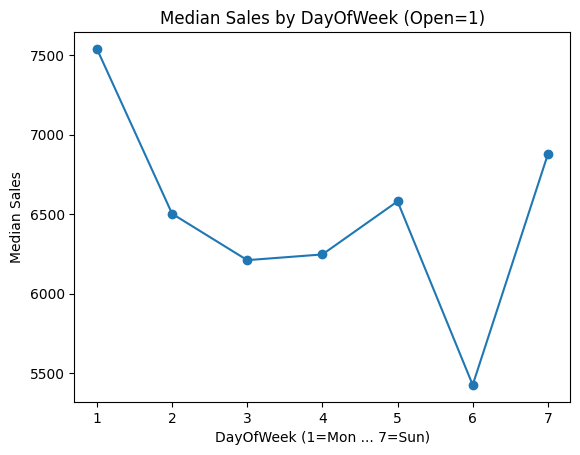

In [97]:
dow = df_open.groupby("DayOfWeek")["Sales"].median()

fig = plt.figure()
plt.plot(dow.index, dow.values, marker="o")
plt.title("Median Sales by DayOfWeek (Open=1)")
plt.xlabel("DayOfWeek (1=Mon ... 7=Sun)")
plt.ylabel("Median Sales")
plt.show()

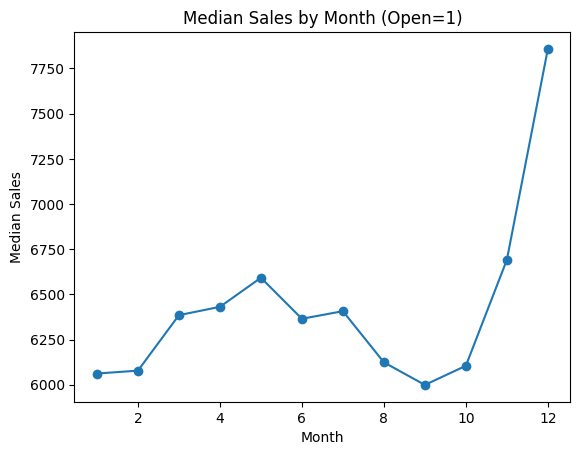

In [98]:
df_open["Year"] = df_open["Date"].dt.year
df_open["Month"] = df_open["Date"].dt.month

month = df_open.groupby("Month")["Sales"].median()

fig = plt.figure()
plt.plot(month.index, month.values, marker="o")
plt.title("Median Sales by Month (Open=1)")
plt.xlabel("Month")
plt.ylabel("Median Sales")
plt.show()

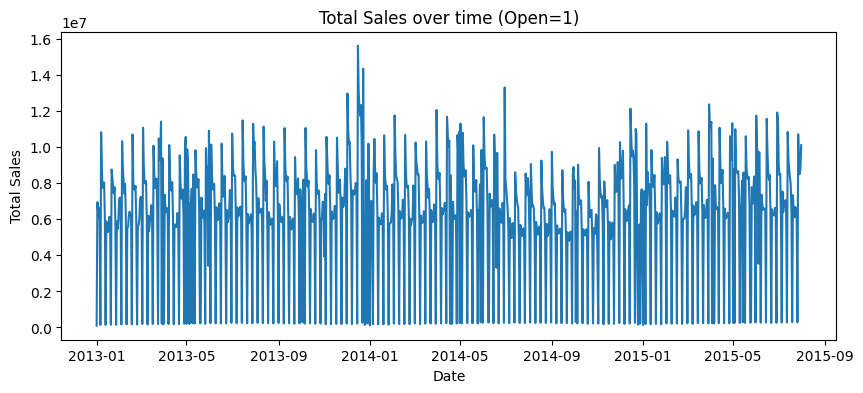

In [99]:
daily = df_open.groupby("Date")["Sales"].sum().sort_index()

fig = plt.figure(figsize=(10,4))
plt.plot(daily.index, daily.values)
plt.title("Total Sales over time (Open=1)")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.show()

## 5) Effets Promo et Holidays

Variables clés :
- `Promo`
- `SchoolHoliday`
- `StateHoliday` (`a/b/c/0`)

On compare les ventes (jours ouverts) selon ces variables.

In [100]:
# Normalise StateHoliday pour éviter mélange 0 / "0"
df_open["StateHoliday"] = df_open["StateHoliday"].astype(str)

summary = (
    df_open.groupby(["Promo", "StateHoliday", "SchoolHoliday"])["Sales"]
    .median()
    .reset_index()
    .sort_values("Sales", ascending=False)
)

summary.head(20)

,Promo,StateHoliday,SchoolHoliday,Sales
11,1,b,0,36227.0
4,0,b,0,33326.0
12,1,b,1,11440.0
6,0,c,1,8397.0
10,1,a,1,8297.5
9,1,a,0,7865.0
8,1,0,1,7757.0
7,1,0,0,7621.0
5,0,b,1,6105.0
2,0,a,0,5728.0


## 6) Variables magasin (store.csv)

`store.csv` fournit des variables fixes par magasin, qui structurent fortement les ventes :

- `StoreType` : 4 modèles de magasins
- `Assortment` : niveau d’assortiment (basic/extra/extended)
- `CompetitionDistance` + `CompetitionOpenSince…`
- `Promo2`, `Promo2SinceYear/Week`, `PromoInterval`

On analyse :
- différences de ventes par `StoreType` / `Assortment`
- influence de `CompetitionDistance` (approche simple par quantiles)
- proportion de valeurs manquantes et stratégie d’imputation

Implication : ces variables devront être **encodées** et certaines devront être transformées en features temporelles (“ancienneté de la concurrence”, “Promo2 active à la date”).

In [101]:
cat_summary = (
    df_open.groupby(["StoreType", "Assortment"])["Sales"]
    .median()
    .sort_values(ascending=False)
)
cat_summary

StoreType  Assortment
b          c             18029.5
           a              9581.0
           b              8081.0
a          c              6874.0
d          c              6586.0
c          a              6452.0
           c              6351.0
d          a              6063.0
a          a              5956.0
Name: Sales, dtype: float64

CompetitionDistance missing: 0.0025888449914257834


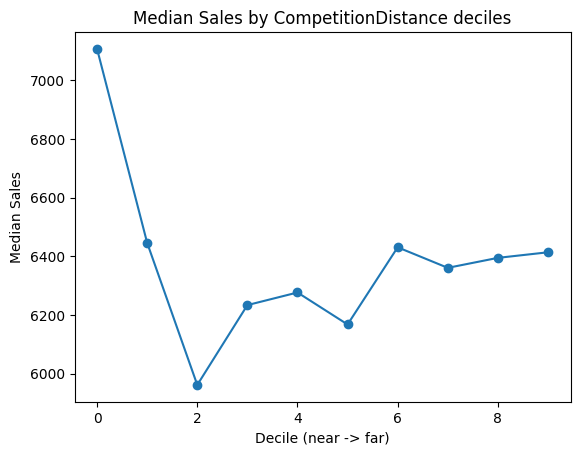

In [102]:
print("CompetitionDistance missing:", df_open["CompetitionDistance"].isna().mean())

tmp = df_open.dropna(subset=["CompetitionDistance"]).copy()
tmp["cd_bin"] = pd.qcut(tmp["CompetitionDistance"], q=10, duplicates="drop")

cd = tmp.groupby("cd_bin")["Sales"].median()

fig = plt.figure()
plt.plot(range(len(cd)), cd.values, marker="o")
plt.title("Median Sales by CompetitionDistance deciles")
plt.xlabel("Decile (near -> far)")
plt.ylabel("Median Sales")
plt.show()

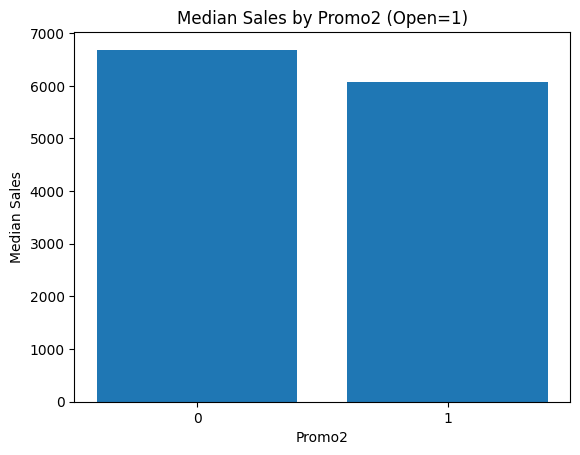

In [103]:
promo2 = df_open.groupby("Promo2")["Sales"].median()

fig = plt.figure()
plt.bar(promo2.index.astype(str), promo2.values)
plt.title("Median Sales by Promo2 (Open=1)")
plt.xlabel("Promo2")
plt.ylabel("Median Sales")
plt.show()

## Exemple de série temporelle par magasin

On visualise un magasin pour voir la volatilité et les périodes de fermeture / promotions.

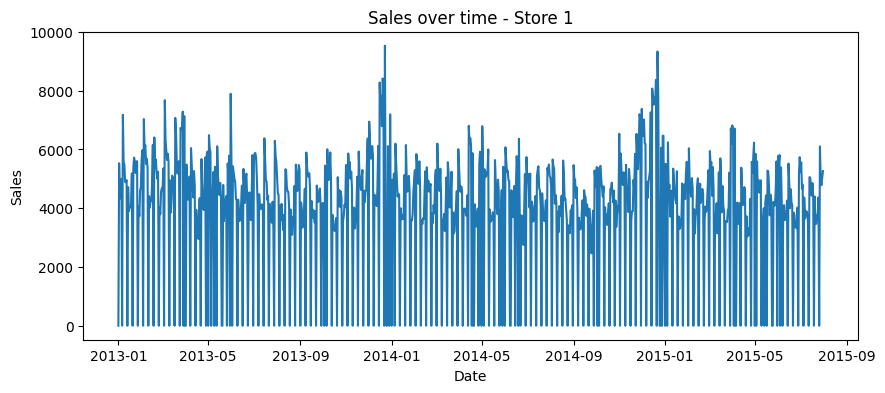

In [104]:
store_id = 1
s = train_merged[train_merged["Store"] == store_id].sort_values("Date")

fig = plt.figure(figsize=(10,4))
plt.plot(s["Date"], s["Sales"])
plt.title(f"Sales over time - Store {store_id}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

## 7) Synthèse : décisions pour le prétraitement (notebook 02)

À partir de l’EDA :

1. **Filtrage / target**
   - Entraîner principalement sur `Open=1` et `Sales>0` (cohérent RMSPE).
   - Pour le test : imposer `Sales=0` si `Open=0`.

2. **Features temporelles**
   - `year`, `month`, `day`, `week`, `dayofweek`
   - éventuellement encodage cyclique (sin/cos) pour `dayofweek` et `month`

3. **Encodage catégoriel**
   - One-hot : `StoreType`, `Assortment`, `StateHoliday`
   - Binaire : `SchoolHoliday`, `Promo`, `Promo2`

4. **Imputation**
   - `CompetitionDistance` : médiane + indicateur “missing”
   - `CompetitionOpenSince…` : construire une date et dériver “mois depuis ouverture concurrent” (+ indicateur missing)
   - `Promo2Since…` + `PromoInterval` : dériver `is_promo2_active(date)` (feature clé)

5. **Plan de test**
   - Split temporel (validation sur la fin de période, pas un split aléatoire)
   - Métrique interne : RMSPE (même formule que Kaggle)

## Prochaine étape

Passer à `02_pretratment.ipynb` :
- construction du dataset final (merge + cleaning)
- création des features
- séparation train/valid temporelle
- baseline model (ex: LightGBM) + métrique RMSPE